<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Applied-Modeling/blob/master/DS_U2_Sprint3_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [2]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [3]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

profile

In [4]:
display(train.head())

display(train.isna().sum())

display(train.City.value_counts(), train.State.value_counts(), train.Violations.value_counts())


,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

CHICAGO              51659
Chicago                 91
chicago                 34
CCHICAGO                16
SCHAUMBURG               6
CHicago                  5
ELK GROVE VILLAGE        4
MAYWOOD                  4
CICERO                   3
CHESTNUT STREET          3
NAPERVILLE               2
ALSIP                    2
EAST HAZEL CREST         2
SKOKIE                   2
ROSEMONT                 2
NILES NILES              2
OAK PARK                 2
CHICAGOCHICAGO           2
ELMHURST                 2
CHARLES A HAYES          1
HIGHLAND PARK            1
BERWYN                   1
SCHILLER PARK            1
BRIDGEVIEW               1
CHCHICAGO                1
CHICAGOHICAGO            1
TINLEY PARK              1
EVANSTON                 1
BOLINGBROOK              1
STREAMWOOD               1
CHICAGO HEIGHTS          1
CHICAGOI                 1
BEDFORD PARK             1
OLYMPIA FIELDS           1
WORTH                    1
OOLYMPIA FIELDS          1
BROADVIEW                1
L

IL    51906
Name: State, dtype: int64

45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING.  MUST PROVIDE.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [5]:
import numpy as np

def wrangle(df):

  def fix_violations(v):
    v = str(v).split('.')[0]
    if v != 'nan':
      v = int(v)
    else:
      v = np.nan
    return v

  def fix_risk(r):

    r = str(r)

    if r != 'nan':
      r = int(str(r).split()[1])
    else:
      r = np.nan

    return r


  df = df.copy()

  #df.Violations = df.Violations.apply(fix_violations)

  df.Risk = df.Risk.apply(fix_risk)

  df['Inspection Date'] = df['Inspection Date'].astype('datetime64[ns]')

  df['InspectionYear'] = df['Inspection Date'].dt.year
  df['InspectionMonth'] = df['Inspection Date'].dt.month
  df['InspectionDay'] = df['Inspection Date'].dt.day

  
  drop_columns = ['AKA Name', 'State', 'City','Location', 'Address', 'License #', 'Inspection Date', 'Inspection ID']

  # Drop the "leaky" feature
  drop_columns.append('Violations')  

  df = df.drop(columns=drop_columns) 

  return df

train_w = wrangle(train)
test_w = wrangle(test)

display(train_w.shape, test_w.shape)
display(train_w.head())
display(test_w.head())
#display(train_w.City.value_counts(), train_w['Facility Type'].value_counts(), train_w['Inspection Type'].value_counts(), train_w['DBA Name'].value_counts())

(51916, 11)

(17306, 11)

,DBA Name,Facility Type,Risk,Zip,Inspection Type,Latitude,Longitude,Fail,InspectionYear,InspectionMonth,InspectionDay
0,"TOM YUM RICE & NOODLE, INC.",Restaurant,1.0,60657.0,Canvass,41.938007,-87.644755,1,2017,9,15
1,FILLING STATION & CONVENIENCE STORE,Grocery Store,3.0,60636.0,Complaint Re-Inspection,41.772402,-87.683603,0,2011,10,20
2,A P DELI,Restaurant,1.0,60649.0,Canvass Re-Inspection,41.758779,-87.575054,0,2016,4,5
3,FRANK'S CHICAGO SHRIMP HOUSE,Restaurant,2.0,60632.0,Canvass,41.812181,-87.707125,0,2016,4,29
4,MORRILL,School,1.0,60629.0,Canvass,NaN,NaN,0,2011,1,10


,DBA Name,Facility Type,Risk,Zip,Inspection Type,Latitude,Longitude,Fail,InspectionYear,InspectionMonth,InspectionDay
0,7 - ELEVEN,Grocery Store,2.0,60605.0,Canvass,41.874481,-87.629357,0,2011,3,22
1,TAQUERIA LOS GALLOS INC,Restaurant,1.0,60623.0,Canvass,41.844070,-87.729807,0,2015,9,15
2,TROTTER'S TO GO,Restaurant,1.0,60614.0,Canvass,41.925128,-87.662041,0,2012,3,2
3,BIG G'S PIZZA,Restaurant,1.0,60607.0,Canvass Re-Inspection,41.869546,-87.655501,1,2016,10,4
4,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,School,2.0,60619.0,Canvass,41.743933,-87.599291,1,2016,4,8


In [6]:
from sklearn.model_selection import train_test_split

target = 'Fail'

X_train, X_val, y_train, y_val = train_test_split(train_w.drop(columns=target), train_w[target], train_size=0.8, random_state=42)

X_test = test_w.drop(columns=target)
y_test = test_w[target]

display(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

X_train['Inspection Type'].value_counts()

(41532, 10)

(10384, 10)

(17306, 10)

(41532,)

(10384,)

(17306,)

Canvass                                   19279
License                                    6247
Canvass Re-Inspection                      5112
Complaint                                  3982
License Re-Inspection                      2413
Complaint Re-Inspection                    1772
Short Form Complaint                       1695
Suspected Food Poisoning                    172
License-Task Force                          172
Consultation                                158
Tag Removal                                 113
Out of Business                              85
Task Force Liquor 1475                       71
Recent Inspection                            55
Suspected Food Poisoning Re-inspection       45
Complaint-Fire                               44
Short Form Fire-Complaint                    31
Package Liquor 1474                          15
Special Events (Festivals)                   15
No Entry                                     15
Complaint-Fire Re-inspection            

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [7]:
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from xgboost import XGBClassifier
import sklearn
from sklearn.metrics import accuracy_score, roc_auc_score
import eli5
from eli5.sklearn import PermutationImportance
import shap
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
display(y_train.value_counts(normalize=True))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of th

0    0.743764
1    0.256236
Name: Fail, dtype: float64

In [8]:
transformers = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)
X_test_transformed = transformers.transform(X_test)


In [9]:
model = RandomForestClassifier(n_estimators=103, random_state=42, n_jobs=-1, max_depth=25, min_samples_leaf=3, max_features=0.3)
model.fit(X_train_transformed, y_train)


permuter = PermutationImportance(
    model, 
    scoring='roc_auc', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

feature_names = X_val.columns.tolist()


In [10]:
print('Shape before removing', X_train.shape)

minimum_importance = 0 
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train_m = X_train[features]

print('Shape after removing ', X_train_m.shape)

X_val_m = X_val[features]
X_test_m = X_test[features]


Shape before removing (41532, 10)
Shape after removing  (41532, 10)


In [11]:
transformers = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

columns = X_train_m.columns

X_train_encoded = pd.DataFrame(transformers.fit_transform(X_train_m), columns=columns)
X_val_encoded = pd.DataFrame(transformers.transform(X_val_m), columns=columns)
X_test_encoded = pd.DataFrame(transformers.transform(X_test_m), columns=columns)


eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model = XGBClassifier(n_estimators=1000, random_state=42, n_jobs=-1, max_depth=21, learning_rate=0.4) 

eval_metric = 'auc'
model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric=eval_metric,
          early_stopping_rounds=200)
          



[0]	validation_0-auc:0.872213	validation_1-auc:0.669752
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 200 rounds.
[1]	validation_0-auc:0.922104	validation_1-auc:0.677301
[2]	validation_0-auc:0.954847	validation_1-auc:0.680216
[3]	validation_0-auc:0.971023	validation_1-auc:0.68029
[4]	validation_0-auc:0.980586	validation_1-auc:0.683805
[5]	validation_0-auc:0.986648	validation_1-auc:0.685153
[6]	validation_0-auc:0.991812	validation_1-auc:0.686502
[7]	validation_0-auc:0.993989	validation_1-auc:0.688566
[8]	validation_0-auc:0.996798	validation_1-auc:0.688519
[9]	validation_0-auc:0.998195	validation_1-auc:0.68939
[10]	validation_0-auc:0.998925	validation_1-auc:0.691172
[11]	validation_0-auc:0.999044	validation_1-auc:0.691346
[12]	validation_0-auc:0.99931	validation_1-auc:0.69065
[13]	validation_0-auc:0.999506	validation_1-auc:0.689909
[14]	validation_0-auc:0.999614	validation_1-auc:0.690073
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.4, max_delta_step=0, max_depth=21,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
y_pred_proba = model.predict_proba(X_val_encoded)[:, -1] # Probability for the last class

val_roc_auc = roc_auc_score(y_val, y_pred_proba)

print(f'Validation ROC AUC score : {model.best_score:0.4f}/{val_roc_auc:0.4f}')

Validation ROC AUC score : 0.7024/0.7024


In [13]:
y_pred_proba = model.predict_proba(X_test_encoded)[:, -1] # Probability for the last class

test_roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Test ROC AUC score : {test_roc_auc:0.4f}')

Test ROC AUC score : 0.7129


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [14]:
eli5.show_weights(
    permuter, 
    top=None, # No limit: show permutation importances for all features
    feature_names=feature_names # must be a list
)



Weight,Feature
0.1622 ± 0.0085,Inspection Type
0.0545 ± 0.0052,InspectionYear
0.0273 ± 0.0028,Latitude
0.0225 ± 0.0024,Longitude
0.0208 ± 0.0043,Zip
0.0115 ± 0.0012,Facility Type
0.0095 ± 0.0024,InspectionMonth
0.0074 ± 0.0027,Risk
0.0047 ± 0.0021,InspectionDay
0.0024 ± 0.0026,DBA Name


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

inspect_type_cat = X_val_encoded['Inspection Type'].value_counts().index
inspect_type_names = X_val['Inspection Type'].value_counts().index

features = ['Inspection Type', 'InspectionYear']

isolated = []

for feature in features:
  isolated.append(
      pdp_isolate(
      model=model, 
      dataset=X_val_encoded, 
      model_features=X_val_encoded.columns, 
      feature=feature
    )
  )

interaction = pdp_interact(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns,
    features=features
)




findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


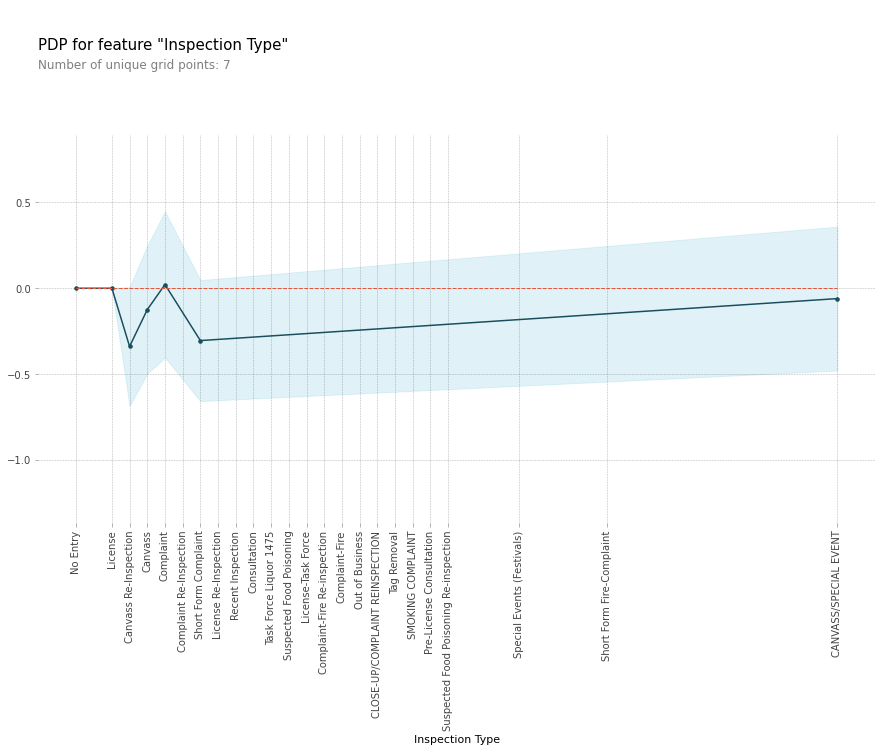

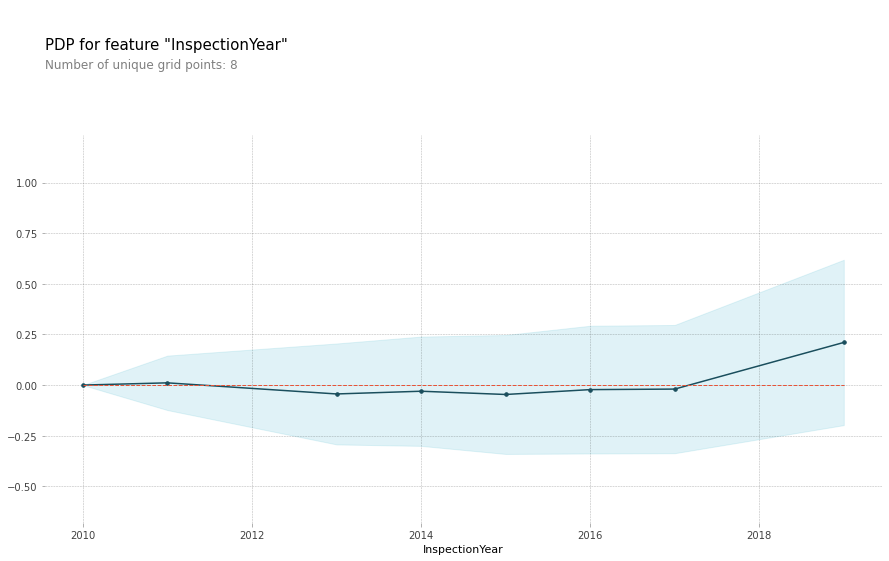

In [16]:
for idx,elem in enumerate(isolated):
  pdp_plot(elem, feature_name=features[idx]);
  if features[idx] == 'Inspection Type':
    # Manually change the xticks labels
    plt.xticks(inspect_type_cat, inspect_type_names, rotation='vertical');




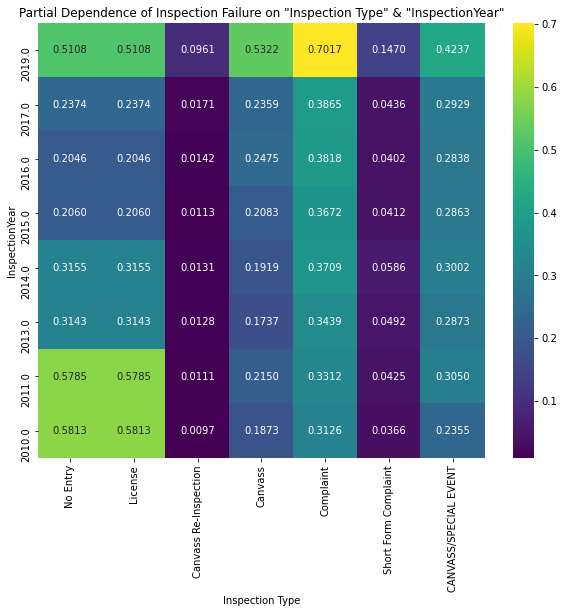

In [17]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(inspect_type_cat, inspect_type_names)))
plt.figure(figsize=(10,8));
sns.heatmap(pdp, annot=True, fmt='.4f', cmap='viridis')
plt.title(f'Partial Dependence of Inspection Failure on "{features[0]}" & "{features[1]}"');

In [18]:
df = pd.DataFrame({
    'pred_proba': y_pred_proba, 
    'failure': y_test
}) 

df= df.merge(X_test_encoded, left_index=True, right_index=True)

passed = df.failure == 0
failed = ~passed
failed_right = (failed) == (df['pred_proba'] > 0.50)
passed_right = (passed) == (df['pred_proba'] <= 0.50)


failed_correct = df[failed&failed_right]
passed_correct = df[passed&passed_right]

correct = df[failed&failed_right | passed&passed_right]

display(failed_correct.shape, passed_correct.shape, correct.shape, df.shape)
display(correct.sample(n=10, random_state=1).sort_values(by='pred_proba'))

row_fail = X_test_encoded.loc[[6063]]

row_pass = X_test_encoded.loc[[8224]]

display(row_pass, row_fail)

(1420, 12)

(11497, 12)

(12917, 12)

(17306, 12)

,pred_proba,failure,DBA Name,Facility Type,Risk,Zip,Inspection Type,Latitude,Longitude,InspectionYear,InspectionMonth,InspectionDay
8224,0.001015,0,-1.0,4.0,3.0,60618.0,7.0,41.939254,-87.702663,2013.0,2.0,22.0
888,0.006021,0,10810.0,5.0,1.0,60622.0,3.0,41.905315,-87.685720,2019.0,1.0,8.0
9015,0.006546,0,145.0,1.0,2.0,60601.0,3.0,41.886567,-87.624385,2011.0,10.0,14.0
9280,0.009473,0,13618.0,1.0,1.0,60630.0,6.0,41.972908,-87.748062,2011.0,4.0,4.0
291,0.010825,0,9201.0,4.0,3.0,60619.0,5.0,41.739733,-87.604763,2017.0,2.0,7.0
9140,0.042953,0,8025.0,1.0,1.0,60639.0,3.0,41.916954,-87.753315,2016.0,8.0,12.0
5062,0.111543,0,-1.0,4.0,3.0,60660.0,3.0,41.994469,-87.658125,2016.0,11.0,9.0
12120,0.239219,0,-1.0,4.0,3.0,60640.0,3.0,41.962153,-87.655235,2013.0,9.0,24.0
13460,0.298269,0,2849.0,1.0,1.0,60616.0,4.0,41.853305,-87.634177,2016.0,12.0,12.0
6063,0.988938,1,10806.0,4.0,3.0,60637.0,1.0,41.772959,-87.609889,2011.0,7.0,11.0


,DBA Name,Facility Type,Risk,Zip,Inspection Type,Latitude,Longitude,InspectionYear,InspectionMonth,InspectionDay
8224,-1.0,4.0,3.0,60618.0,7.0,41.939254,-87.702663,2013.0,2.0,22.0


,DBA Name,Facility Type,Risk,Zip,Inspection Type,Latitude,Longitude,InspectionYear,InspectionMonth,InspectionDay
6063,10806.0,4.0,3.0,60637.0,1.0,41.772959,-87.609889,2011.0,7.0,11.0


In [19]:
explainer = shap.TreeExplainer(model)

shap.initjs()

shap_values = explainer.shap_values(row_pass)
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row_pass,
    #matplotlib=True, # This does not work if link is set to 'logit'
    link='logit' # For classification, this shows predicted probabilities
)

  
  

In [20]:
shap.initjs()

shap_values = explainer.shap_values(row_fail)
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row_fail,
    #matplotlib=True, # This does not work if link is set to 'logit'
    link='logit' # For classification, this shows predicted probabilities
)